In [3]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Instance of CNN Model

class Simple1DCNN(torch.nn.Module):
    def __init__(self,cnn_1):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=15, out_channels=cnn_1, kernel_size=1, stride=2)
        # self.layer1 = torch.nn.Conv1d(in_channels=12000, out_channels=cnn_1, kernel_size=1, stride=2)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=cnn_1, out_channels=5, kernel_size=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)

        log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return log_probs

In [1]:
#Conenct to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


### PREPROCESSING ON TESTING DATA

In [5]:
#Load in desired testing dataset
testdata = pd.read_csv('/content/drive/MyDrive/Masters Final Code/Testing Data /1K.csv')


In [6]:
lb = LabelEncoder()
testdata['label'] = lb.fit_transform(testdata['label'])

In [7]:
testdata2 = testdata.transpose()
testdata2 = testdata2.head(testdata2.shape[0] -1)
testdata2.columns = testdata2.columns.map(str)
testdata2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
1001,64.992220,25.519580,13.068030,21.881770,6.750694,23.310040,9.460737,5.230873,7.037568,24.372080,24.982450,4.980621,16.455580,6.378368,2.563555,5.029450,14.069030,13.910340,9.680470,15.033420,2.606281,15.314190,13.763850,19.611190,17.224650,1.733451,19.574570,2.496414,24.011960,22.858360,47.349460,-0.366222,16.846220,63.264870,22.919400,72.389890,-20.584730,-5.371257,61.082790,-15.320290,...,86.077450,99.368260,-23.911250,-12.878810,31.373030,7.827997,5.523850,107.120000,74.724560,-2.822962,31.937620,11.200290,42.649610,81.865890,36.652730,52.873310,54.643390,59.297460,53.086940,84.902490,6.988738,95.583970,-2.761925,78.630940,80.004270,34.607990,13.336590,89.114040,-6.607257,74.114200,68.697160,34.974210,66.454050,15.060880,61.006500,50.294500,68.468270,85.177150,0.305185,97.094640
1002,63.219430,25.166860,13.368605,21.927779,7.103412,23.015595,10.666110,4.448759,5.283181,25.822823,24.332225,4.870205,18.292780,6.240348,2.121891,3.636982,15.568847,11.987257,8.652989,15.975020,3.480407,14.249900,12.334574,19.730810,16.825926,0.411527,19.221855,1.229698,23.327997,22.895168,50.661940,-6.431431,12.743958,59.170279,19.744942,63.234571,-15.255628,-6.475417,58.276388,-19.775269,...,82.902992,97.259624,-22.324018,-12.112035,45.021669,12.597352,11.228672,105.755110,80.659417,-2.861301,34.667346,13.815004,37.910924,82.172601,38.531336,48.027280,51.491931,52.542152,59.711900,88.383654,12.938932,94.495143,-2.907613,77.051376,81.468816,28.098047,13.482275,84.536381,-3.325449,73.669467,63.881798,34.790184,71.054714,14.493467,52.740636,42.181994,62.096349,87.408476,2.160787,96.281851
1003,61.430485,24.416367,13.867454,20.981397,7.925827,23.104451,11.723416,3.551030,4.575108,25.961157,24.290160,5.244390,19.209293,5.310716,2.058927,3.232435,16.968835,10.107120,8.111176,17.205385,2.923080,12.727940,12.269154,19.000077,17.613636,0.819593,18.997428,0.585539,22.982886,22.212866,53.846697,-9.079859,8.427735,56.762575,14.736189,58.985892,-13.474183,-0.781365,50.374682,-19.277190,...,83.622402,98.005503,-24.646199,-14.671729,50.988975,13.776094,19.166624,105.875568,85.380993,-0.690699,38.695606,16.402426,35.062488,82.475191,43.272547,43.704598,48.057743,46.293586,64.915229,85.187519,16.915562,92.529357,-3.038372,70.817259,77.605632,23.590637,11.306356,81.325487,1.123151,78.237329,58.007579,38.381512,76.749486,11.694553,45.865273,37.859647,55.518350,85.516757,2.496745,96.678787
1004,59.482812,23.731362,14.198956,20.029624,8.758313,22.894858,13.134910,3.415064,4.290790,26.044260,23.648024,5.690138,19.594727,5.601782,1.925220,2.889222,17.417874,8.769034,7.765937,18.305337,3.045593,11.181710,11.929766,18.436471,17.962555,0.383924,19.010680,0.763767,22.770066,21.366792,61.692639,-8.820267,2.157429,50.788199,9.176752,54.000087,-11.507026,6.812868,42.458867,-19.539296,...,83.931751,97.158674,-25.935015,-16.327115,56.199011,16.119554,25.950508,101.691822,89.352504,-0.941370,40.806441,19.337895,32.650923,82.610992,46.367138,39.018675,42.855732,42.766746,69.371559,80.398819,22.357801,90.183486,-6.708791,65.771987,79.623804,19.443527,10.725713,78.155744,4.396711,78.337213,51.655314,43.468477,81.559947,9.811138,40.875001,32.291021,49.685463,83.258259,4.844779,95.409674
1005,57.955647,23.078802,14.290749,18.900714,10.257728,22.776582,14.168542,3.141717,3.752853,26.158874,23.606464,6.296284,19.718878,5.863579,2.095302,2.572479,17.901468,7.498012,6.968546,19.364999,3.038153,9.575359,11.647695,17.343691,18.034912,-0.383042,18.917763,1.002696,22.225216,20.389712,68.725446,-7.076795,-1.371015,43.343456,4.029435,45.928073,-9.293231,9.809394,38.011674,-17.831746,...,82.212073,98.605691,-26.642875,-17.317168,61.584999,21.750137,32.697913,96.974490,95.492869,2.317180,43.912754,21.541133,30.805593,8

In [8]:
# NORMALISATION MIN MAX

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


Complete_x = []


for i in range(0,150):
  x = testdata2.iloc[:, i].values
  y = testdata.loc[:,['label']].values

  x_data = x
  x_data = np.array(x_data)
  x_data = x_data.reshape(-1,1)

  #array to hold normalised data
  data_array = []
  norm = []

  #MinMax done here, normalised data added to data array
  scaler = MinMaxScaler()
  norm = scaler.fit_transform(x_data)
  data_array = norm
  data_array = data_array.flatten()

  if (i == 0):
    Complete_x = data_array
    normTest = pd.DataFrame(data = Complete_x, columns = [f'gesture{i}'])

  #further gestures are appended to the dataframe
  if (i > 0):
    Complete_x = data_array
    normTest[f'gesture{i}'] = Complete_x

transposed_normTest = normTest.transpose()
df_label = testdata.loc[:,['label']].values
label = df_label
transposed_normTest['label'] = label
transposed_normTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999,label
gesture0,0.978101,0.964818,0.951414,0.936820,0.925378,0.916796,0.909429,0.905278,0.902440,0.901093,0.902770,0.904324,0.906819,0.908608,0.912634,0.917301,0.922903,0.930472,0.936687,0.943695,0.950060,0.956994,0.962702,0.967852,0.972639,0.977299,0.980893,0.984515,0.987023,0.988036,0.987600,0.986847,0.984975,0.982530,0.980137,0.977167,0.974222,0.970947,0.967875,0.964735,...,0.823669,0.824030,0.824881,0.825996,0.826884,0.827799,0.828683,0.829498,0.830543,0.831506,0.832496,0.833330,0.833981,0.834341,0.834331,0.834108,0.833674,0.832917,0.832117,0.831287,0.830404,0.829392,0.828219,0.827113,0.826095,0.825111,0.824383,0.823672,0.823185,0.822982,0.822928,0.823194,0.823711,0.824351,0.825177,0.826224,0.827188,0.828155,0.829169,0
gesture1,0.914388,0.911777,0.906220,0.901148,0.896316,0.895944,0.896657,0.897858,0.900401,0.905219,0.910943,0.918325,0.925101,0.934295,0.942865,0.950486,0.957842,0.964253,0.970861,0.977340,0.983145,0.987459,0.991371,0.993067,0.993815,0.993311,0.991355,0.989031,0.986122,0.982863,0.980238,0.977024,0.974941,0.972887,0.971003,0.970129,0.969308,0.968638,0.968527,0.969415,...,0.944827,0.945444,0.946244,0.946888,0.947411,0.947820,0.947928,0.947821,0.947444,0.946836,0.946238,0.945368,0.944500,0.943620,0.942821,0.942020,0.941314,0.940651,0.940049,0.939562,0.939239,0.939222,0.939354,0.939565,0.939944,0.940712,0.941474,0.942523,0.943433,0.944597,0.945550,0.946487,0.947291,0.948170,0.948821,0.949390,0.949555,0.949509,0.949303,0
gesture2,0.892772,0.894922,0.898492,0.900864,0.901521,0.905331,0.910328,0.913884,0.918597,0.924153,0.930534,0.938183,0.946910,0.954239,0.960830,0.967198,0.973182,0.978930,0.984505,0.989934,0.993406,0.996974,0.998988,1.000000,0.999660,0.998211,0.995588,0.992488,0.989521,0.986240,0.983406,0.980175,0.976940,0.973623,0.970375,0.967868,0.965084,0.963077,0.962079,0.961349,...,0.938693,0.939297,0.939968,0.940508,0.940689,0.940719,0.940596,0.940272,0.939815,0.939288,0.938506,0.937842,0.937200,0.936429,0.935648,0.934822,0.933971,0.933231,0.932679,0.932235,0.931946,0.931884,0.931969,0.932169,0.932637,0.933100,0.933624,0.934172,0.934775,0.935275,0.935847,0.936490,0.937073,0.937467,0.937692,0.937644,0.937438,0.937021,0.936505,0
gesture3,0.999648,1.000000,0.992754,0.985467,0.976824,0.965601,0.955088,0.946255,0.938678,0.931020,0.925349,0.920019,0.916681,0.913764,0.911964,0.910012,0.909700,0.909905,0.910766,0.912680,0.915066,0.918654,0.922325,0.925972,0.930041,0.934569,0.939354,0.943002,0.945352,0.947652,0.950015,0.951390,0.952460,0.953184,0.952772,0.951523,0.950207,0.948277,0.946016,0.943815,...,0.944104,0.944781,0.945481,0.946108,0.946918,0.947813,0.948568,0.949381,0.950134,0.950842,0.951441,0.951966,0.952250,0.952348,0.952191,0.951765,0.951231,0.950619,0.950009,0.949307,0.948611,0.947842,0.946917,0.945995,0.945008,0.944199,0.943670,0.943283,0.942937,0.942680,0.942750,0.943017,0.943563,0.944202,0.944806,0.945428,0.946115,0.946805,0.947451,0
gesture4,0.887499,0.890388,0.897124,0.903942,0.916224,0.927144,0.935804,0.942305,0.948696,0.954048,0.958870,0.962404,0.965725,0.968018,0.969773,0.970164,0.968533,0.964979,0.960915,0.957099,0.952295,0.947451,0.943320,0.939062,0.935578,0.933134,0.930963,0.928923,0.927827,0.927056,0.926363,0.926453,0.927566,0.928977,0.931073,0.933185,0.935596,0.938249,0.940940,0.943200,...,0.960419,0.959716,0.959068,0.958550,0.958017,0.957634,0.957340,0.957382,0.957520,0.957866,0.958345,0.959175,0.960113,0.960975,0.961829,0.962586,0.963536,0.964369,0.965159,0.965874,0.966453,0.966982,0.967169,0.966994,0.966595,0.966012,0.965413,0.964707,0.963918,0.963168,0.962287,0.961453,0.960530,0.959549,0.958693,0.957953,0.957520,0.957044,0.956760,0
...,...,...,...

In [9]:
#Load PCA
import pickle

with open('/content/drive/MyDrive/Masters Final Code/Extra/pca.pkl', 'rb') as fid:

    pca_reload = pickle.load(fid)

In [10]:
#Apply PCA 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

transposed_normTest.columns = transposed_normTest.columns.map(str)
features = [str(i) for i in range(0,12000)]
x = transposed_normTest.loc[:, features].values
y = transposed_normTest.loc[:,['label']].values

newdata_transformed = pca_reload.transform(x)
pc = pca_reload.explained_variance_ratio_.cumsum()
x1 = StandardScaler().fit(newdata_transformed)
X1 = x1.transform(newdata_transformed)

full_newdf_test = pd.DataFrame(data = X1
             , columns = [f'pc_stdscaled_{i}' for i in range(len(pc))])
full_finalTest = pd.concat([full_newdf_test, testdata[['label']]], axis = 1)
print(full_finalTest)
print(full_newdf_test.shape)

     pc_stdscaled_0  pc_stdscaled_1  ...  pc_stdscaled_14  label
0          0.904158        1.453562  ...        -0.956714      0
1          1.301364        0.913081  ...         0.009275      0
2          1.288975        1.536999  ...        -0.249891      0
3          1.418521        0.977535  ...        -0.846739      0
4          1.407738        1.320620  ...        -1.375016      0
..              ...             ...  ...              ...    ...
145       -1.473562        0.766156  ...        -1.060461      4
146       -0.914364       -1.677280  ...         3.236150      4
147       -0.518260       -1.973554  ...         3.049734      4
148       -0.813838       -1.309734  ...        -0.028570      4
149       -0.961893       -0.929212  ...        -0.442658      4

[150 rows x 16 columns]
(150, 15)


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        self.y = torch.unsqueeze(torch.tensor(df.pop('label').values, dtype=torch.long), dim=-1)
        self.X = torch.unsqueeze(torch.tensor(df.iloc[:,:].values, dtype=torch.float32), dim=-1)
        # self.X = torch.tensor(df.iloc[:,:].values, dtype=torch.float32)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [12]:
init_data = MyDataset(full_finalTest)
val_set = init_data
len(val_set)

150

In [13]:
test_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=8)

In [14]:
print(len(test_loader))


19


In [15]:
x,y = next(iter(test_loader))
print(x.shape)
print(y.shape)

torch.Size([8, 15, 1])
torch.Size([8, 1])


In [17]:
#Load Model

model = torch.load('/content/drive/MyDrive/Masters Final Code/Extra/MODEL_CNN.pt', map_location=device)
print(model)

Simple1DCNN(
  (layer1): Conv1d(15, 400, kernel_size=(1,), stride=(2,))
  (act1): ReLU()
  (layer2): Conv1d(400, 5, kernel_size=(1,), stride=(1,))
)


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


array_predicted = torch.tensor([])
array_labels =  torch.tensor([])

loss_fn = nn.CrossEntropyLoss()


val_loss = 0
precision, recall, f1, accuracy = [], [], [], []
model.eval()
with torch.no_grad():
    for i,(data, label) in enumerate(test_loader):
        outputs = model(data.to(device))
        val_loss += loss_fn(outputs, label.to(device))

        predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

        array_predicted = torch.cat((array_predicted.cpu(),predicted_classes.cpu()),0) 
        array_labels = torch.cat((array_labels.cpu(), label.cpu()),0)

        # calculate P/R/F1/A metrics for batch
        for acc, metric in zip((precision, recall, f1), 
                                (precision_score, recall_score, f1_score)):
            acc.append(
                metric(label.cpu(), predicted_classes.cpu(), average="macro")
            )
        accuracy.append(accuracy_score(label.cpu(), predicted_classes.cpu()))


In [19]:
#Evaluation Metrics

from sklearn.metrics import precision_score

acc = accuracy_score(array_predicted, array_labels)
print("Accuracy: ",round((acc*100),0))
print("Precision: ",round((100 * (precision_score(array_labels, array_predicted, average="macro"))),0))
print("Recall: ",round((100 * (recall_score(array_labels, array_predicted, average="macro"))),0))
print("F1: ", round((100 * (f1_score(array_labels, array_predicted, average="macro"))),0))

Accuracy:  93.0
Precision:  93.0
Recall:  93.0
F1:  93.0


In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(array_labels, array_predicted)
cm

array([[29,  1,  0,  0,  0],
       [ 0, 30,  0,  0,  0],
       [ 0,  0, 29,  1,  0],
       [ 0,  2,  0, 27,  1],
       [ 0,  0,  1,  5, 24]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

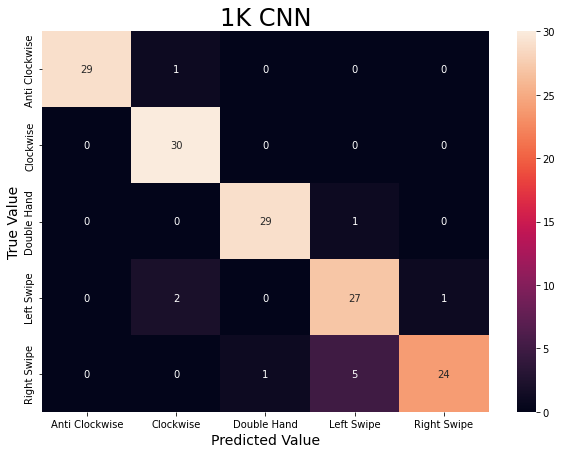

In [21]:
#Confusion Matrix

labels=['Anti Clockwise', 'Clockwise', 'Double Hand', 'Left Swipe', 'Right Swipe']


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted Value',fontsize=14)
plt.ylabel('True Value',fontsize=14)
plt.title('1K CNN',fontsize=24)
plt.xticks(np.arange(5)+0.5,labels)
plt.yticks(np.arange(5)+0.5,labels)

from google.colab import files
plt.savefig("1KCNN.png")
files.download("1KCNN.png") 
#gesture_list = ["anti-clockwise","clockwise","Double Hand", "Left Swipe", "Right Swipe"]